In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [2]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [3]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

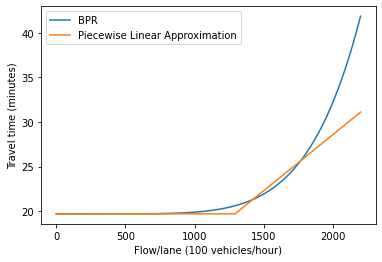

In [4]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [5]:
###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 44.4 $/hr; median: 37.2 $/hr


Text(0, 0.5, '% of population')

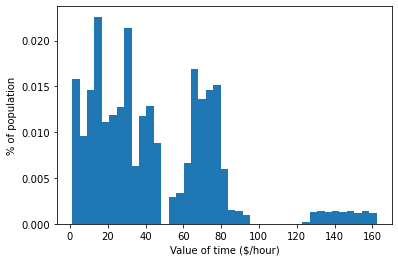

In [6]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [7]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.63
18.7
26.3
30.26
37.36
43.92
63.55
68.53
74.5
80.0
162.22


## To modify below (See marking)

In [22]:
demand_multiplier = [25,75]

###### Evaluate Travel Time Metrics ###### 
def evaluate_avg_tt_in_discount(solution_, demand_multiplier):
    """
    Average travel time, ineligible only
    """
    
    ineligible_tt = sum(solution_['users_in'][i, j, t] * apx_bpr_cost(solution_['edge_flows'][j, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[j],
                                                                    b = apx_slope / demand_multiplier[j])
                                 for i in range(num_ineligible) for j in range(2) for t in range(T))/(T * num_ineligible)
    
    return ineligible_tt

def evaluate_avg_tt_el_discount(solution_, demand_multiplier):
    """
    Average travel time, eligible only
    """
    
    ## Frank: Not sure in the original code, why one needs to divide by num_eligible twice. 
    # Express lane:
    eligible_tt = sum(( solution_['users_el'][j, t] /num_eligible)*apx_bpr_cost(solution_['edge_flows'][j, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[j],
                                                               b = apx_slope / demand_multiplier[j])
                                for j in range(2) for t in range(T)) /(T * num_eligible)
    
    return eligible_tt

def evaluate_total_tt_discount(solution_,demand_multiplier):
    """
    Total travel time
    """
    ineligible_tt = evaluate_avg_tt_in_discount(solution_, demand_multiplier) * num_ineligible * T
    eligible_tt = evaluate_avg_tt_el_discount(solution_, demand_multiplier) * num_eligible * T
    
    return eligible_tt + ineligible_tt

def evaluate_avg_travel_time_discount(solution_,demand_multiplier):
    """
    Average travel time
    """
    return evaluate_total_tt_discount(solution_,demand_multiplier)/(T*num_total)

def evaluate_avg_express_tt_discount(solution_,demand_multiplier):
    """
    Average travel time on express lane
    """
    avg_EL_tt = sum(apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                 b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return avg_EL_tt

def evaluate_avg_general_tt_discount(solution_,demand_multiplier):
    """
    Average travel time on general purpose lanes
    """
    avg_GP_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) for t in range(T))/T
    return avg_GP_tt
    
def evaluate_avg_tt_savings_discount(solution_,demand_multiplier):
    """
    Average travel time savings   
    """
    delta_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) - 
                   apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return delta_tt


###### Evaluate Lane Usage Metrics ###### 
def evaluate_express_usage_discount(solution_,demand_multiplier):
    """
    Average share of all/el/inel users using express lane
    """
    share_eligible = sum(solution_['users_el'][0, t] for t in range(T))/(T * num_eligible)
    share_ineligible = sum(solution_['users_in'][i, 0, t] for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    share_all = (sum(solution_['users_el'][0, t] for t in range(T)) +
               sum(solution_['users_in'][i, 0, t] for i in range(num_ineligible) for t in range(T)))/(T * num_total)
    
    return share_all, share_eligible, share_ineligible




def evaluate_express_usage_percentile_inel_discount(solution_,demand_multiplier,percentiles):
    share_ineligible = {}
    for p,thresh in percentiles.items():
        # number of ineligible users in the group
        if p >= 10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        
        share_ineligible[p] = 0
        for t in range(T):
            if p>=10:
                share_ineligible[p]+=sum( solution_['users_in'][i, 0, t]
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                           (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
            else:
                share_ineligible[p]+=sum( solution_['users_in'][i, 0, t]
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
        if these_ineligible > 0:
            share_ineligible[p]=share_ineligible[p]/these_ineligible
    
    return share_ineligible


###### Evaluate Travel Cost Metrics ###### 
def evaluate_total_travel_cost_in_discount(solution_, tau, demand_multiplier):
    
    """
    Total travel cost for ineligible only
    """
    
    ineligible_travel_cost = sum(solution_['users_in'][i, 0, t] * vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[0],
                                                                                                  b = apx_slope/demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T))
    ineligible_travel_cost += sum(solution_['users_in'][i, 1, t]*vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[1],
                                                                                                  b = apx_slope/demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T))
    
    toll_revenue_in = evaluate_total_revenue_in_discount(solution_, tau, demand_multiplier)
    return ineligible_travel_cost + toll_revenue_in


def evaluate_total_travel_cost_el_discount(solution_, tau, demand_multiplier, discount_ratio):
    
    """
    Total travel cost for eligible only
    """
    
    eligible_travel_cost = sum((solution_['users_el'][j, t] /num_eligible)*vot_eligible[j, t]*apx_bpr_cost(solution_['edge_flows'][j, t],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[j],
                                                                                                           b = apx_slope/demand_multiplier[j])  
                               for i in range(num_eligible) for j in range(2) for t in range(T))
    
    toll_revenue_el = evaluate_total_revenue_el_discount(solution_, tau, demand_multiplier, discount_ratio)
    
    return eligible_travel_cost + toll_revenue_el

def evaluate_total_revenue_in_discount(solution_, tau, demand_multiplier):
    """
    Total toll revenue from ineligible users 
    """
    total_toll_revenue_in = sum(tau * solution_['users_in'][i, 0, t] for i in range(num_ineligible) for t in range(T))
    
    return total_toll_revenue_in

def evaluate_total_revenue_el_discount(solution_, tau, demand_multiplier, discount_ratio):
    """
    Total toll revenue from eligible users
    """
    total_toll_revenue_el = sum(tau * (1 - discount_ratio) * solution_['users_el'][0, t] for t in range(T))
    
    return total_toll_revenue_el

def evaluate_total_travel_cost_percentile_inel_discount(solution_,tau,demand_multiplier,percentiles):
    """
    Total travel cost for each ineligible group percentile
    """
    social_cost={}
    for p,thresh in percentiles.items():
        social_cost[p]=0
        for t in range(T):
            if p>=10:
                social_cost[p]+=sum(solution_['users_in'][i, j, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][j, t],capacity = bpr_true_capacity*demand_multiplier[j], b = apx_slope/demand_multiplier[j]) 
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                      (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0] for j in range(2))
                
                social_cost[p]+=sum(solution_['users_in'][i, 0, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                                                         (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0] )
            else:
                social_cost[p]+=sum(solution_['users_in'][i, j, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][j, t],capacity = bpr_true_capacity*demand_multiplier[j],b = apx_slope/demand_multiplier[j])
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0] for j in range(2))
                social_cost[p]+=sum(solution_['users_in'][i, 0, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
    return social_cost

def evaluate_avg_travel_cost_percentile_inel_discount(social_cost_by_percentile):
    """
    Average travel cost for each ineligible group percentile  
    """
    avg_social_cost={}
    for p,thresh in percentiles.items():
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        if these_ineligible>0:
            avg_social_cost[p]=social_cost_by_percentile[p]/these_ineligible
        else:
            avg_social_cost[p]=0
    return avg_social_cost

# Solver 2, Discount:

In [23]:
# Solver 2, Discount:

def OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express and general purpose lanes:
    m1.addConstrs((edge_flows[j, t] == sum(users_in[i, j, t] for i in range(num_ineligible)) + \
                  users_el[j, t] for j in range(2) for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(2) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(2)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(2)) == num_eligible for t in range(T)))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    
    ## To edit below:
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible[i,t] for i in range(num_eligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [24]:
def _extract_solution_discount(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [25]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 2 - Discount:

In [26]:
###### Initialize matrices for results ###### 
# Optimization problems are iterated over tolls budgets

avg_tt_in_discount = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_el_discount = np.zeros((len(tau_arr), len(B_arr)))
total_tt_discount = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_discount = np.zeros((len(tau_arr), len(B_arr)))
avg_EL_tt_discount = np.zeros((len(tau_arr), len(B_arr)))
avg_GP_tt_discount = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_savings_discount = np.zeros((len(tau_arr), len(B_arr)))

exp_all_discount = np.zeros((len(tau_arr), len(B_arr)))
exp_el_discount = np.zeros((len(tau_arr), len(B_arr)))
exp_in_discount = np.zeros((len(tau_arr), len(B_arr)))
exp_in_p_discount = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

total_tc_in_discount = np.zeros((len(tau_arr), len(B_arr)))
total_tc_el_discount = np.zeros((len(tau_arr), len(B_arr)))
total_tr_discount = np.zeros((len(tau_arr), len(B_arr)))
total_tc_in_p_discount = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}
avg_tc_in_p_discount = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

In [27]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
# print(tau_arr)
# print()
# print(B_arr)
# print()

In [ ]:
t_1 = time.time()

demand_multiplier = [25,75]

# For saving data:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_discount/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)

# Copied from above:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]



total_count = len(tau_arr) * len(B_arr)


for toll_idx, toll in enumerate(tau_arr):
    
    print()
    print("Toll:", toll)
    print()
    
    for budget_idx, budget in enumerate(B_arr):
        
        print()
        print("Budget:", budget)
        print()
        
        discount_ratio = budget/(toll*T) if toll != 0 else 1
        
        m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
                    vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
                      fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
                     a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        m_discount.optimize()
        
        # Extract Solution:
        solution_set = _extract_solution_discount(m_discount)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
            
        ### Frank - To modify below:
        # Storing data:
        data_edge_flows = solution_set["edge_flows"].T.reshape(10)
        data_eps_flow = solution_set["eps_flows"].T.reshape(10)
        data_users_el = solution_set["users_el"].T.reshape(10)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*2))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        file_name = path_directory + "toll_" + to_str(toll) + "_budget_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)
        
        
        # Extract Metrics:
        
#         avg_tt_in_discount[toll_idx, budget_idx] = evaluate_avg_tt_in_discount(solution_set, demand_multiplier)
#         avg_tt_el_discount[toll_idx, budget_idx] = evaluate_avg_tt_el_discount(solution_set, demand_multiplier)
#         total_tt_discount[toll_idx, budget_idx] = evaluate_total_tt_discount(solution_set,demand_multiplier)
#         avg_tt_discount[toll_idx, budget_idx] = evaluate_avg_travel_time_discount(solution_set,demand_multiplier)
#         avg_EL_tt_discount[toll_idx, budget_idx] = evaluate_avg_express_tt_discount(solution_set,demand_multiplier)
#         avg_GP_tt_discount[toll_idx, budget_idx] = evaluate_avg_general_tt_discount(solution_set,demand_multiplier)
#         avg_tt_savings_discount[toll_idx, budget_idx] = evaluate_avg_tt_savings_discount(solution_set,demand_multiplier)

#         exp_all_discount[toll_idx, budget_idx], exp_el_discount[toll_idx, budget_idx], exp_in_discount[toll_idx, budget_idx] \
#             = evaluate_express_usage_discount(solution_set,demand_multiplier)

#         total_tc_in_discount[toll_idx, budget_idx] = evaluate_total_travel_cost_in_discount(solution_set, toll, demand_multiplier)
#         total_tc_el_discount[toll_idx, budget_idx] = evaluate_total_travel_cost_el_discount(solution_set, toll, demand_multiplier, discount_ratio)
#         total_tr_discount[toll_idx, budget_idx] = evaluate_total_revenue_in_discount(solution_set, toll, demand_multiplier) \
#             + evaluate_total_revenue_el_discount(solution_set, toll, demand_multiplier, discount_ratio)
        
#         share_inel_all_discount = evaluate_express_usage_percentile_inel_discount(solution_set,demand_multiplier,percentiles)
#         total_social_cost_inel_all_discount = evaluate_total_travel_cost_percentile_inel_discount(solution_set,toll,demand_multiplier,percentiles)
#         avg_social_cost_inel_all_discount = evaluate_avg_travel_cost_percentile_inel_discount(total_social_cost_inel_all_discount)
#         for p in range(11):
#             exp_in_p_discount[p*10][toll_idx,budget_idx] = share_inel_all_discount[p*10]
#             total_tc_in_p_discount[p*10][toll_idx,budget_idx] = total_social_cost_inel_all_discount[p*10]
#             avg_tc_in_p_discount[p*10][toll_idx,budget_idx] = avg_social_cost_inel_all_discount[p*10]
            

        
        

t_2 = time.time()
print("Run time:", t_2 - t_1)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4f369e61
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.12s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
 

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
   8   8.50880702e+05  8.50880702e+05  8.61e-13 2.13e-14  2.92e-10     0s

Barrier solved model in 8 iterations and 0.17 seconds (0.11 work units)
Optimal objective 8.50880702e+05


Edge flows: [[2000. 2000

   8   8.50880702e+05  8.50880702e+05  8.61e-13 2.13e-14  2.92e-10     0s

Barrier solved model in 8 iterations and 0.17 seconds (0.11 work units)
Optimal objective 8.50880702e+05


Edge flows: [[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x1be45648
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 4e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Bar

  10  -2.38361888e+08 -2.38366094e+08  1.63e-08 1.14e-13  1.24e-04     0s
  11  -2.38363367e+08 -2.38365582e+08  7.81e-09 1.14e-13  6.51e-05     0s
  12  -2.38363878e+08 -2.38365161e+08  2.55e-08 1.14e-13  3.77e-05     0s
  13  -2.38363900e+08 -2.38365144e+08  2.48e-08 1.14e-13  3.66e-05     0s
  14  -2.38363957e+08 -2.38365102e+08  2.36e-08 1.14e-13  3.36e-05     0s
  15  -2.38364039e+08 -2.38365045e+08  2.29e-08 1.14e-13  2.96e-05     0s
  16  -2.38364122e+08 -2.38364988e+08  2.02e-08 1.14e-13  2.55e-05     0s
  17  -2.38364224e+08 -2.38364921e+08  1.58e-08 1.14e-13  2.05e-05     0s
  18  -2.38364299e+08 -2.38364872e+08  1.25e-08 8.88e-16  1.68e-05     0s
  19  -2.38364359e+08 -2.38364833e+08  8.68e-09 8.88e-16  1.39e-05     0s
  20  -2.38364405e+08 -2.38364804e+08  5.99e-09 8.88e-16  1.17e-05     0s
  21  -2.38364446e+08 -2.38364779e+08  3.72e-09 8.88e-16  9.78e-06     0s
  22  -2.38364478e+08 -2.38364760e+08  4.93e-09 8.88e-16  8.30e-06     0s
  23  -2.38364498e+08 -2.38364748e+08 

  55  -4.77583300e+08 -4.77583300e+08  3.64e-12 1.14e-13  2.17e-14     1s

Barrier solved model in 55 iterations and 0.79 seconds (0.42 work units)
Optimal objective -4.77583300e+08

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xa454fef7
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB

  25  -9.56020406e+08 -9.56020670e+08  4.85e-09 2.27e-13  3.88e-06     0s
  26  -9.56020425e+08 -9.56020660e+08  6.89e-09 2.27e-13  3.44e-06     0s
  27  -9.56020443e+08 -9.56020650e+08  7.83e-09 4.44e-16  3.05e-06     0s
  28  -9.56020459e+08 -9.56020642e+08  6.25e-09 2.27e-13  2.68e-06     0s
  29  -9.56020470e+08 -9.56020636e+08  5.53e-09 2.27e-13  2.45e-06     0s
  30  -9.56020483e+08 -9.56020629e+08  4.99e-09 2.27e-13  2.15e-06     0s
  31  -9.56020493e+08 -9.56020624e+08  5.87e-09 8.88e-16  1.93e-06     0s
  32  -9.56020502e+08 -9.56020620e+08  5.29e-09 2.27e-13  1.73e-06     0s
  33  -9.56020510e+08 -9.56020616e+08  6.19e-09 4.44e-16  1.56e-06     0s
  34  -9.56020518e+08 -9.56020611e+08  5.29e-09 2.27e-13  1.36e-06     0s
  35  -9.56020526e+08 -9.56020608e+08  4.18e-09 8.88e-16  1.21e-06     0s
  36  -9.56020530e+08 -9.56020605e+08  3.65e-09 2.27e-13  1.11e-06     0s
  37  -9.56020535e+08 -9.56020603e+08  4.02e-09 8.88e-16  9.93e-07     0s
  38  -9.56020539e+08 -9.56020602e+08 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.49719006e+09 -1.38195033e+10  6.64e+06 8.04e+02  1.85e+06     0s
   1  -8.58942311e+08 -1.10759412e+10  3.57e+05 4.32e+01  1.01e+05     0s
   2  -1.23293389e+09 -1.00475495e+10  4.71e+04 1.30e+01  1.34e+04     0s
   3  -1.42813345e+09 -9.33649724e+09  4.15e+02 1.01e-01  2.32e+02     0s
   4  -1.43019104e+09 -5.11035283e+09  7.22e+01 1.44e-02  6.35e+01     0s
   5  -1.43313518e+09 -4.17487921e+09  3.66e+01 4.44e-03  4.38e+01     0s
   6  -1.43388163e+09 -1.67082788e+09  3.66e-05 4.44e-09  3.48e+00     0s
   7  -1.43409520e+09 -1.44011748e+09  3.82e-11 4.55e-13  8.85e-02     0s
   8  -1.43427846e+09 -1.43470387e+09  4.73e-11 4.55e-13  6.25e-03     0s
   9  -1.43438949e+09 -1.43459197e+09  6.91e-09 4.55e-13  2.98e-03     0s
  10  -1.43444707e+09 -1.43448646e+09  1.82e-08 2.27e-13  5.79e-04     0s
  11  -1.43445367e+09 -1.43446002e+09  2.04

  42  -1.67367650e+09 -1.67367651e+09  9.60e-11 4.44e-16  5.36e-08     1s
  43  -1.67367650e+09 -1.67367651e+09  5.71e-11 2.27e-13  2.53e-08     1s
  44  -1.67367651e+09 -1.67367651e+09  3.52e-11 4.55e-13  1.15e-08     1s
  45  -1.67367651e+09 -1.67367651e+09  2.66e-11 2.27e-13  5.85e-09     1s
  46  -1.67367651e+09 -1.67367651e+09  1.86e-11 2.27e-13  1.56e-09     1s
  47  -1.67367651e+09 -1.67367651e+09  2.50e-12 4.55e-13  2.68e-11     1s
  48  -1.67367651e+09 -1.67367651e+09  3.18e-12 2.27e-13  2.71e-14     1s

Barrier solved model in 48 iterations and 0.58 seconds (0.38 work units)
Optimal objective -1.67367651e+09

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x1ae74354
Model has 10 quadratic objective terms
Coefficient statisti

   9   8.60871380e+05  8.48680238e+05  1.22e-04 1.41e-08  1.83e-01     0s
  10   8.57705733e+05  8.54383050e+05  2.11e-05 2.45e-09  5.00e-02     0s
  11   8.57325174e+05  8.55300259e+05  9.77e-06 1.13e-09  3.05e-02     0s
  12   8.57132526e+05  8.55580223e+05  7.47e-06 8.67e-10  2.34e-02     0s
  13   8.57019398e+05  8.55738051e+05  5.68e-06 6.59e-10  1.93e-02     0s
  14   8.56824860e+05  8.56005724e+05  3.12e-06 3.61e-10  1.23e-02     0s
  15   8.56731192e+05  8.56131493e+05  2.26e-06 2.62e-10  9.02e-03     0s
  16   8.56660003e+05  8.56221987e+05  1.64e-06 1.90e-10  6.59e-03     0s
  17   8.56628848e+05  8.56261938e+05  1.27e-06 1.46e-10  5.52e-03     0s
  18   8.56589071e+05  8.56312249e+05  8.07e-07 9.32e-11  4.17e-03     0s
  19   8.56554890e+05  8.56353112e+05  5.83e-07 6.74e-11  3.04e-03     0s
  20   8.56533997e+05  8.56378153e+05  3.96e-07 4.54e-11  2.35e-03     0s
  21   8.56517586e+05  8.56397290e+05  2.68e-07 3.08e-11  1.81e-03     0s
  22   8.56498382e+05  8.56419004e+05 

  10  -4.77558057e+08 -4.77648426e+08  5.20e-09 1.14e-13  1.33e-03     0s
  11  -4.77573651e+08 -4.77583659e+08  1.16e-08 1.14e-13  1.47e-04     0s
  12  -4.77574482e+08 -4.77583891e+08  1.11e-08 8.88e-16  1.38e-04     0s
  13  -4.77576215e+08 -4.77583485e+08  8.88e-09 8.88e-16  1.07e-04     0s
  14  -4.77577806e+08 -4.77582463e+08  8.58e-09 4.44e-16  6.84e-05     0s
  15  -4.77578711e+08 -4.77582072e+08  5.91e-09 1.14e-13  4.94e-05     0s
  16  -4.77579178e+08 -4.77581863e+08  5.81e-09 8.88e-16  3.94e-05     0s
  17  -4.77579348e+08 -4.77581666e+08  1.31e-08 4.44e-16  3.41e-05     0s
  18  -4.77579427e+08 -4.77581632e+08  8.77e-09 4.44e-16  3.24e-05     0s
  19  -4.77579914e+08 -4.77581336e+08  1.86e-08 1.14e-13  2.09e-05     0s
  20  -4.77580038e+08 -4.77581258e+08  1.55e-08 2.27e-13  1.79e-05     0s
  21  -4.77580159e+08 -4.77581184e+08  1.13e-08 1.14e-13  1.51e-05     0s
  22  -4.77580261e+08 -4.77581122e+08  1.17e-08 4.44e-16  1.27e-05     0s
  23  -4.77580365e+08 -4.77581063e+08 

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.21s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.04641313e+09 -1.01740818e+10  6.64e+06 8.04e+02  1.24e+06     0s
   1  -7.08085289e+08 -7.40016681e+09  4.00e+05 4.85e+01  7.54e+04     0s
   2  -8.33725209e+08 -6.69897919e+09  5.33e+04 9.82e+00  1.01e+04     0s
   3  -9.50475216e+08 -6.24076568e+09  4.77e+02 6.87e-02  1.66e+02     0s
   4  -9.51793456e+08 -3.83330675e+09  1.08e+02 1.31e-02  5.33e+01     0s
   5  -9.54695360e+08 -3.18983781e+09  5.67e

  41  -1.19523674e+09 -1.19523675e+09  2.09e-10 5.55e-17  1.66e-08     0s
  42  -1.19523674e+09 -1.19523675e+09  1.43e-10 2.27e-13  3.93e-09     0s
  43  -1.19523674e+09 -1.19523674e+09  4.41e-11 2.27e-13  7.71e-10     0s
  44  -1.19523674e+09 -1.19523674e+09  1.11e-11 2.27e-13  6.27e-12     0s

Barrier solved model in 44 iterations and 0.49 seconds (0.36 work units)
Optimal objective -1.19523674e+09

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x1a1ef87b
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Pr

   4   5.83683340e+06 -3.63935506e+09  6.20e+02 7.80e-02  1.33e+02     0s
   5   2.37851667e+06 -3.32720273e+09  2.48e+02 3.00e-02  7.80e+01     0s
   6   1.58851941e+06 -9.36180868e+08  2.37e+01 2.87e-03  1.46e+01     0s
   7   1.16230439e+06 -9.71758084e+07  2.37e-05 2.87e-09  1.45e+00     0s
   8   1.08789160e+06  3.34154579e+05  7.95e-08 9.63e-12  1.11e-02     0s
   9   9.61380024e+05  7.12726663e+05  2.19e-08 2.43e-12  3.65e-03     0s
  10   9.16893806e+05  8.71343205e+05  7.69e-09 3.04e-13  6.69e-04     0s
  11   9.04664492e+05  8.82761884e+05  4.82e-09 1.40e-13  3.22e-04     0s
  12   8.94993716e+05  8.87632924e+05  5.66e-09 3.53e-14  1.08e-04     0s
  13   8.91683379e+05  8.89428139e+05  3.00e-09 1.14e-13  3.31e-05     0s
  14   8.90741329e+05  8.89888523e+05  2.31e-09 1.14e-13  1.25e-05     0s
  15   8.90439995e+05  8.90028140e+05  3.56e-09 1.14e-13  6.05e-06     0s
  16   8.90308031e+05  8.90086879e+05  3.44e-09 1.14e-13  3.25e-06     0s
  17   8.90244177e+05  8.90115203e+05 

Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.30644743e+09 -4.24051643e+09  6.64e+06 4.86e+02  1.00e+06     0s
   1  -4.41716797e+08 -2.92317794e+09  3.26e+05 2.44e+01  4.96e+04     0s
   2  -1.89436295e+08 -2.62113752e+09  1.05e+03 7.68e-02  2.37e+02     0s
   3  -2.32617156e+08 -1.62845946e+09  4.62e+01 3.38e-03  4.56e+01     0s
   4  -2.37240248e+08 -1.22342128e+09  7.46e+00 5.46e-04  2.95e+01     0s
   5  -2.37875187e+08 -2.76388188e+08  7.46e-06 5.46e-10  1.13e+00     0s
   6  -2.37969266e+08 -2.38997597e+08  1.13e-07 8.24e-12  3.02e-02     0s
   7  -2.38184562e+08 -2.38642439e+08  4.53e

   5  -7.15417234e+08 -2.87170290e+09  8.56e+01 1.04e-02  3.82e+01     0s
   6  -7.16054454e+08 -1.06130052e+09  5.89e+00 7.13e-04  5.15e+00     0s
   7  -7.16322861e+08 -7.30987805e+08  5.89e-06 7.13e-10  2.16e-01     0s
   8  -7.16462056e+08 -7.17181205e+08  1.61e-07 1.95e-11  1.06e-02     0s
   9  -7.16660536e+08 -7.17012863e+08  6.94e-08 8.42e-12  5.18e-03     0s
  10  -7.16770837e+08 -7.16857218e+08  3.00e-09 2.27e-13  1.27e-03     0s
  11  -7.16788260e+08 -7.16802522e+08  1.01e-08 4.44e-16  2.10e-04     0s
  12  -7.16792177e+08 -7.16800891e+08  6.35e-09 1.14e-13  1.28e-04     0s
  13  -7.16794775e+08 -7.16799431e+08  5.52e-09 1.14e-13  6.84e-05     0s
  14  -7.16795707e+08 -7.16798799e+08  2.39e-09 1.14e-13  4.54e-05     0s
  15  -7.16796691e+08 -7.16798125e+08  2.50e-08 1.14e-13  2.11e-05     0s
  16  -7.16797166e+08 -7.16797699e+08  2.41e-08 1.14e-13  7.83e-06     0s
  17  -7.16797173e+08 -7.16797694e+08  2.45e-08 2.27e-13  7.66e-06     0s
  18  -7.16797183e+08 -7.16797686e+08 

  10  -1.19521243e+09 -1.19526527e+09  6.34e-09 4.55e-13  7.76e-04     0s
  11  -1.19522557e+09 -1.19523951e+09  1.39e-08 2.27e-13  2.05e-04     0s
  12  -1.19522928e+09 -1.19523802e+09  8.40e-09 4.55e-13  1.29e-04     0s
  13  -1.19523180e+09 -1.19523675e+09  7.86e-09 2.27e-13  7.26e-05     0s
  14  -1.19523289e+09 -1.19523607e+09  7.07e-09 2.27e-13  4.67e-05     0s
  15  -1.19523374e+09 -1.19523563e+09  1.85e-08 4.44e-16  2.78e-05     0s
  16  -1.19523421e+09 -1.19523526e+09  8.09e-09 2.27e-13  1.53e-05     0s
  17  -1.19523425e+09 -1.19523523e+09  8.48e-09 4.55e-13  1.45e-05     0s
  18  -1.19523435e+09 -1.19523515e+09  6.37e-09 2.27e-13  1.17e-05     0s
  19  -1.19523447e+09 -1.19523504e+09  5.38e-09 4.55e-13  8.34e-06     0s
  20  -1.19523457e+09 -1.19523494e+09  7.10e-09 4.44e-16  5.47e-06     0s
  21  -1.19523463e+09 -1.19523490e+09  3.26e-09 2.27e-13  3.95e-06     0s
  22  -1.19523466e+09 -1.19523487e+09  3.30e-09 2.22e-16  3.03e-06     0s
  23  -1.19523469e+09 -1.19523484e+09 

   1  -4.91729348e+08 -5.35327932e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   2.39074918e+07 -4.68020195e+09  5.92e+04 8.82e+00  9.07e+03     0s
   3   8.54244984e+06 -4.30820948e+09  2.27e+03 2.98e-01  4.06e+02     0s
   4   5.80916554e+06 -3.63930616e+09  6.20e+02 7.80e-02  1.33e+02     0s
   5   2.40032526e+06 -3.32715824e+09  2.48e+02 3.00e-02  7.80e+01     0s
   6   1.63998047e+06 -9.36133856e+08  2.37e+01 2.87e-03  1.46e+01     0s
   7   1.21678544e+06 -9.71226029e+07  2.37e-05 2.87e-09  1.45e+00     0s
   8   1.14072581e+06  2.89689227e+05  9.67e-08 1.17e-11  1.25e-02     0s
   9   9.91958891e+05  7.02913762e+05  2.68e-08 3.06e-12  4.25e-03     0s
  10   9.34317256e+05  8.79030348e+05  7.54e-09 3.88e-13  8.13e-04     0s
  11   9.18904735e+05  8.90989494e+05  3.37e-09 1.69e-13  4.10e-04     0s
  12   9.06357989e+05  8.99066197e+05  5.37e-09 3.49e-14  1.07e-04     0s
  13   9.02981011e+05  9.00879355e+05  4.08e-09 1.14e-13  3.09e-05     0s
  14   9.02088096e+05  9.01326611e+05 

   0  -6.18284677e+09 -4.24046164e+09  6.64e+06 4.86e+02  1.00e+06     0s
   1  -4.84646654e+08 -2.92312311e+09  3.26e+05 2.44e+01  4.96e+04     0s
   2  -1.89535594e+08 -2.62108304e+09  1.05e+03 7.68e-02  2.37e+02     0s
   3  -2.32572923e+08 -1.62840374e+09  4.62e+01 3.38e-03  4.56e+01     0s
   4  -2.37188044e+08 -1.22336723e+09  7.46e+00 5.46e-04  2.95e+01     0s
   5  -2.37822357e+08 -2.76446720e+08  7.46e-06 5.46e-10  1.14e+00     0s
   6  -2.37922796e+08 -2.39079990e+08  1.36e-07 9.98e-12  3.40e-02     0s
   7  -2.38154513e+08 -2.38664888e+08  5.46e-08 3.98e-12  1.50e-02     0s
   8  -2.38305879e+08 -2.38639737e+08  5.46e-09 1.14e-13  9.81e-03     0s
   9  -2.38342556e+08 -2.38373533e+08  3.70e-09 8.88e-16  9.10e-04     0s
  10  -2.38352950e+08 -2.38363216e+08  5.64e-09 2.22e-16  3.02e-04     0s
  11  -2.38356732e+08 -2.38359957e+08  5.89e-09 1.14e-13  9.48e-05     0s
  12  -2.38357653e+08 -2.38359294e+08  6.40e-09 1.14e-13  4.82e-05     0s
  13  -2.38358412e+08 -2.38358725e+08 

  11  -9.56003833e+08 -9.56020713e+08  8.67e-09 4.44e-16  2.48e-04     0s
  12  -9.56008793e+08 -9.56018148e+08  3.17e-09 2.27e-13  1.37e-04     0s
  13  -9.56011894e+08 -9.56016216e+08  2.77e-09 4.55e-13  6.35e-05     0s
  14  -9.56013159e+08 -9.56015448e+08  6.27e-09 2.27e-13  3.36e-05     0s
  15  -9.56013940e+08 -9.56014976e+08  2.00e-08 2.27e-13  1.52e-05     0s
  16  -9.56014376e+08 -9.56014601e+08  7.72e-09 2.27e-13  3.30e-06     0s
  17  -9.56014496e+08 -9.56014497e+08  2.02e-08 2.27e-13  1.02e-08     0s
  18  -9.56014497e+08 -9.56014497e+08  1.17e-10 2.27e-13  1.02e-11     0s

Barrier solved model in 18 iterations and 0.28 seconds (0.21 work units)
Optimal objective -9.56014497e+08

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerpri

  13   9.12261843e+05  9.12142800e+05  2.51e-09 1.14e-13  1.75e-06     0s
  14   9.12230059e+05  9.12175595e+05  1.29e-09 2.27e-13  8.00e-07     0s
  15   9.12217044e+05  9.12188952e+05  1.02e-09 1.14e-13  4.13e-07     0s
  16   9.12210690e+05  9.12195440e+05  7.34e-10 2.27e-13  2.24e-07     0s
  17   9.12207586e+05  9.12198616e+05  1.32e-09 1.14e-13  1.32e-07     0s
  18   9.12205082e+05  9.12201159e+05  3.57e-10 1.14e-13  5.76e-08     0s
  19   9.12203886e+05  9.12202365e+05  1.66e-10 1.14e-13  2.23e-08     0s
  20   9.12203174e+05  9.12203081e+05  1.89e-11 8.88e-16  1.38e-09     0s

Barrier solved model in 20 iterations and 0.30 seconds (0.21 work units)
Optimal objective 9.12203174e+05

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprin

   8   8.67028141e+05  8.54652737e+05  1.50e-03 1.74e-07  1.86e-01     0s
   9   8.62774949e+05  8.60377554e+05  1.80e-04 2.09e-08  3.61e-02     0s
  10   8.61930998e+05  8.61328206e+05  2.65e-05 3.07e-09  9.07e-03     0s
  11   8.61716247e+05  8.61560670e+05  5.48e-06 6.36e-10  2.34e-03     0s
  12   8.61650252e+05  8.61631196e+05  3.28e-07 3.81e-11  2.87e-04     0s
  13   8.61643142e+05  8.61638510e+05  5.62e-08 6.35e-12  6.97e-05     0s
  14   8.61641033e+05  8.61640659e+05  1.54e-08 1.71e-13  5.63e-06     0s
  15   8.61640848e+05  8.61640844e+05  1.37e-09 2.27e-13  5.81e-08     0s
  16   8.61640846e+05  8.61640846e+05  7.26e-10 1.14e-13  5.85e-11     0s

Barrier solved model in 16 iterations and 0.25 seconds (0.19 work units)
Optimal objective 8.61640846e+05

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a

  13  -7.16791714e+08 -7.16795920e+08  5.54e-09 4.44e-16  6.18e-05     0s
  14  -7.16793415e+08 -7.16794888e+08  2.91e-09 1.14e-13  2.16e-05     0s
  15  -7.16793978e+08 -7.16794508e+08  4.28e-09 1.14e-13  7.79e-06     0s
  16  -7.16794175e+08 -7.16794366e+08  1.50e-09 1.14e-13  2.82e-06     0s
  17  -7.16794251e+08 -7.16794309e+08  9.40e-10 1.14e-13  8.49e-07     0s
  18  -7.16794276e+08 -7.16794288e+08  3.61e-10 1.14e-13  1.71e-07     0s
  19  -7.16794281e+08 -7.16794283e+08  1.00e-10 2.27e-13  3.32e-08     0s
  20  -7.16794282e+08 -7.16794283e+08  1.86e-10 3.64e-15  2.82e-09     0s
  21  -7.16794282e+08 -7.16794282e+08  4.00e-11 1.14e-13  1.94e-11     0s

Barrier solved model in 21 iterations and 0.30 seconds (0.22 work units)
Optimal objective -7.16794282e+08

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize 

  11   9.30512810e+05  9.16074490e+05  1.44e-09 2.27e-13  2.12e-04     0s
  12   9.22971170e+05  9.21277912e+05  1.28e-09 2.27e-13  2.49e-05     0s
  13   9.22307143e+05  9.21866995e+05  1.11e-09 1.05e-15  6.47e-06     0s
  14   9.22133591e+05  9.22019330e+05  2.39e-09 4.44e-16  1.68e-06     0s
  15   9.22103211e+05  9.22046109e+05  1.38e-09 2.27e-13  8.39e-07     0s
  16   9.22087062e+05  9.22060676e+05  8.83e-10 2.27e-13  3.88e-07     0s
  17   9.22079334e+05  9.22067580e+05  4.93e-10 2.22e-16  1.73e-07     0s
  18   9.22074810e+05  9.22071632e+05  1.63e-10 2.27e-13  4.67e-08     0s
  19   9.22073911e+05  9.22072510e+05  1.07e-10 2.27e-13  2.06e-08     0s
  20   9.22073312e+05  9.22073094e+05  4.09e-11 1.83e-15  3.21e-09     0s

Barrier solved model in 20 iterations and 0.28 seconds (0.21 work units)
Optimal objective 9.22073312e+05

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6

   7   1.14858170e+06  1.93355336e+05  1.89e-05 1.38e-09  2.81e-02     0s
   8   9.78281750e+05  8.28525518e+05  2.11e-09 2.66e-15  4.40e-03     0s
   9   9.42753012e+05  9.02034210e+05  2.62e-09 1.14e-13  1.20e-03     0s
  10   9.27899612e+05  9.18118206e+05  6.15e-09 1.14e-13  2.87e-04     0s
  11   9.23509971e+05  9.21199646e+05  2.66e-09 1.14e-13  6.79e-05     0s
  12   9.22477739e+05  9.21817867e+05  2.28e-09 1.14e-13  1.94e-05     0s
  13   9.22205111e+05  9.21984910e+05  1.44e-09 1.14e-13  6.47e-06     0s
  14   9.22138335e+05  9.22027485e+05  2.11e-09 1.14e-13  3.26e-06     0s
  15   9.22104060e+05  9.22051337e+05  2.73e-09 1.14e-13  1.55e-06     0s
  16   9.22089405e+05  9.22061623e+05  1.59e-09 1.14e-13  8.17e-07     0s
  17   9.22080207e+05  9.22067814e+05  9.60e-10 1.14e-13  3.64e-07     0s
  18   9.22075335e+05  9.22071270e+05  2.75e-10 1.14e-13  1.20e-07     0s
  19   9.22073376e+05  9.22073045e+05  9.07e-11 1.55e-15  9.72e-09     0s

Barrier solved model in 19 iterations

  14  -4.77573214e+08 -4.77574940e+08  5.19e-09 4.44e-16  2.54e-05     0s
  15  -4.77573854e+08 -4.77574527e+08  2.45e-09 1.14e-13  9.90e-06     0s
  16  -4.77574090e+08 -4.77574366e+08  2.49e-09 4.44e-16  4.05e-06     0s
  17  -4.77574179e+08 -4.77574301e+08  3.17e-09 1.14e-13  1.79e-06     0s
  18  -4.77574223e+08 -4.77574270e+08  5.62e-10 1.14e-13  6.87e-07     0s
  19  -4.77574244e+08 -4.77574252e+08  1.08e-10 1.14e-13  1.14e-07     0s
  20  -4.77574247e+08 -4.77574248e+08  2.67e-10 1.14e-13  1.20e-08     0s
  21  -4.77574248e+08 -4.77574248e+08  3.50e-11 1.14e-13  3.76e-10     0s
  22  -4.77574248e+08 -4.77574248e+08  1.73e-11 1.14e-13  7.58e-12     0s

Barrier solved model in 22 iterations and 0.30 seconds (0.23 work units)
Optimal objective -4.77574248e+08

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize 

  11   9.46819334e+05  9.20667462e+05  3.31e-09 2.27e-13  3.84e-04     0s
  12   9.34348449e+05  9.29400604e+05  3.82e-09 2.27e-13  7.27e-05     0s
  13   9.32146800e+05  9.30644659e+05  2.92e-09 4.70e-15  2.21e-05     0s
  14   9.31557498e+05  9.30977935e+05  3.15e-09 2.27e-13  8.52e-06     0s
  15   9.31362701e+05  9.31096823e+05  2.81e-09 2.27e-13  3.91e-06     0s
  16   9.31277190e+05  9.31151204e+05  2.05e-09 2.27e-13  1.85e-06     0s
  17   9.31239954e+05  9.31176210e+05  2.36e-09 2.27e-13  9.37e-07     0s
  18   9.31221082e+05  9.31189813e+05  1.60e-09 2.27e-13  4.60e-07     0s
  19   9.31214305e+05  9.31194458e+05  1.09e-09 2.27e-13  2.92e-07     0s
  20   9.31208424e+05  9.31198585e+05  5.70e-10 2.27e-13  1.45e-07     0s
  21   9.31204584e+05  9.31201619e+05  2.15e-10 4.55e-13  4.36e-08     0s
  22   9.31203290e+05  9.31202786e+05  1.73e-10 2.27e-13  7.41e-09     0s

Barrier solved model in 22 iterations and 0.33 seconds (0.22 work units)
Optimal objective 9.31203290e+05

Guro

   6   1.79433108e+06 -9.35992841e+08  2.37e+01 2.87e-03  1.46e+01     0s
   7   1.38009786e+06 -9.69631116e+07  2.37e-05 2.87e-09  1.45e+00     0s
   8   1.29786702e+06  1.62431307e+05  1.46e-07 1.77e-11  1.67e-02     0s
   9   1.07970399e+06  6.70102788e+05  4.28e-08 5.03e-12  6.02e-03     0s
  10   9.79742218e+05  8.99643250e+05  7.54e-09 5.68e-13  1.18e-03     0s
  11   9.56374621e+05  9.17720625e+05  7.05e-09 2.59e-13  5.68e-04     0s
  12   9.46562585e+05  9.24510879e+05  1.06e-08 1.40e-13  3.24e-04     0s
  13   9.38561573e+05  9.28830908e+05  8.82e-09 5.90e-14  1.43e-04     0s
  14   9.34496704e+05  9.30199746e+05  7.77e-09 2.44e-14  6.31e-05     0s
  15   9.32760446e+05  9.30751633e+05  8.27e-09 1.10e-14  2.95e-05     0s
  16   9.32150309e+05  9.30929389e+05  9.35e-09 6.52e-15  1.79e-05     0s
  17   9.31839822e+05  9.31019533e+05  1.04e-08 1.14e-13  1.21e-05     0s
  18   9.31620279e+05  9.31082473e+05  8.46e-09 1.14e-13  7.90e-06     0s
  19   9.31507286e+05  9.31114982e+05 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.81204479e+09 -4.24029726e+09  6.64e+06 4.86e+02  1.00e+06     0s
   1  -6.13436234e+08 -2.92295863e+09  3.26e+05 2.44e+01  4.96e+04     0s
   2  -1.89833479e+08 -2.62091958e+09  1.05e+03 7.68e-02  2.37e+02     0s
   3  -2.32440259e+08 -1.62823662e+09  4.62e+01 3.38e-03  4.56e+01     0s
   4  -2.37031497e+08 -1.22320514e+09  7.46e+00 5.46e-04  2.95e+01     0s
   5  -2.37664030e+08 -2.76623667e+08  7.46e-06 5.46e-10  1.15e+00     0s
   6  -2.37786934e+08 -2.39251483e+08  1.93e-07 1.41e-11  4.30e-02     0s
   7  -2.38068661e+08 -2.38718106e+08  7.88e-08 5.77e-12  1.91e-02     0s
   8  -2.38278349e+08 -2.38693695e+08  2.90e-09 1.14e-13  1.22e-02     0s
   9  -2.3833329

  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.70838705e+10 -1.23763145e+10  6.64e+06 8.04e+02  1.85e+06     0s
   1  -6.56695994e+08 -9.63166235e+09  3.57e+05 4.32e+01  1.01e+05     0s
   2   3.38877107e+07 -8.61368949e+09  5.09e+04 1.41e+01  1.45e+04     0s
   3   5.72396332e+06 -7.93849092e+09  4.53e+02 9.20e-02  2.43e+02     0s
   4   5.19158703e+06 -3.85333322e+09  1.07e+02 1.60e-02  7.12e+01     0s
   5   2.24933451e+06 -2.73392554e+09  4.28e+01 5.18e-03  4.43e+01     0s
   6


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x636e53a0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.32223036e+10 -8.03247285e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -7.66083772e+08 -5.24530111e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -2.66613298e+07 -4.64817032e+0


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x78562d6c
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 8e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.22371569e+10 -2.08365672e+07  6.64e+06 7.71e

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi = _extract_solution_discount(m_discount)

print(solution_gurobi["edge_flows"])
print()
print(solution_gurobi["eps_flows"])



In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



## Discount, Test:

In [ ]:
time_1 = time.time()


demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible
discount_ratio = budget/(toll*T)

# toll = 1.0
# budget = 3.0

# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()


m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_discount.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

In [ ]:
solution_discount = _extract_solution_discount(m_discount)

In [ ]:
print(solution_discount["edge_flows"])
print()
print(solution_discount["eps_flows"])



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)